# ObsID : 0945060134, SRCNUM : 1, Instru : EPN
Not on Simbad

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import glob

from astropy.io import fits
from astropy.stats import poisson_conf_interval

import stingray as st
from stingray import Lightcurve, AveragedPowerspectrum
from stingray.pulse.pulsar import fold_events
from stingray.pulse.search import plot_profile
from stingray.pulse.search import epoch_folding_search, z_n_search
from stingray.gti import create_gti_mask
from stingray.pulse.search import search_best_peaks
from stingray.stats import fold_detection_level, z2_n_detection_level

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

plt.rcParams['figure.figsize'] = [10,5]

## Light curve

In [2]:
def periodicity(file, gtis, max_gti):
    hdul = fits.open(file)
    print()
    print(color.BOLD +file+ color.END)
    hdul.info()
    
    rate_data = hdul[1].columns
    print()
    print(rate_data)
        
    time = hdul[1].data.field('TIME')
    rate = hdul[1].data.field('RATE')
    error = hdul[1].data.field('ERROR')
    backrate = hdul[1].data.field('BACKV')
    
    lcs = []
    backlcs = []
    lcs.append(Lightcurve(time, rate, error, gti=gtis, input_counts=False))
    backlcs.append(Lightcurve(time, backrate, error, gti=gtis, input_counts=False))
    
    for i in range(len(lcs)):
        plt.xlabel('Time (s)')
        plt.ylabel('Countrate (/s)')
        plt.plot(lcs[i].time, lcs[i].countrate, color='steelblue', lw=1, ds='steps-mid', label='Source')
        plt.plot(backlcs[i].time, backlcs[i].countrate, color='firebrick',lw=1, ls='--', ds='steps-mid', label='Background')
        plt.title(f'{file}')
        plt.legend(loc='upper right')
        plt.grid()
        for j in range(len(lcs[i].gti)-1):
            plt.axvspan(lcs[i].gti[j][1],lcs[i].gti[j+1][0],color='purple',alpha=0.25)
        plt.show()

    avg_ps = AveragedPowerspectrum(lcs[0],segment_size=max_gti)
    
    def linear_fit(log_freq, slope, intercept):
        return slope * log_freq + intercept

    valid = (avg_ps.freq > 0) & (avg_ps.power > 0)
    log_freq = np.log10(avg_ps.freq[valid])
    log_power = np.log10(avg_ps.power[valid])

    params, _ = curve_fit(linear_fit, log_freq, log_power)
    slope, intercept = params
    
    # Ligne ajustée
    fitted_line = 10**(slope * log_freq + intercept)
    
    plt.plot(avg_ps.freq, avg_ps.power, lw=1, color='steelblue', label="Averaged PSD")
    plt.loglog(10**log_freq, fitted_line, color='firebrick', linestyle='--', lw=1, label=f"Fit: y={slope:.2f}x+{intercept:.2f}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (/rms)")
    plt.title(f'{file}')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [3]:
def periodicity_rebin(file, gtis, max_gti, dt_rebin):
    hdul = fits.open(file)
    time = hdul[1].data.field('TIME')
    rate = hdul[1].data.field('RATE')
    error = hdul[1].data.field('ERROR')
    backrate = hdul[1].data.field('BACKV')
    
    lcs = []
    lc = Lightcurve(time, rate, error, gti=gtis, input_counts=False)
    lcs.append(lc.rebin(dt_rebin))
    
    for i in range(len(lcs)):
        plt.xlabel('Time (s)')
        plt.ylabel('Countrate (/s)')
        plt.plot(lcs[i].time, lcs[i].countrate, color='steelblue', lw=1, ds='steps-mid', label='Source')
        plt.title(f'Time bin size : {dt_rebin}s')
        plt.legend(loc='upper right')
        plt.grid()
        for j in range(len(lcs[i].gti)-1):
            plt.axvspan(lcs[i].gti[j][1],lcs[i].gti[j+1][0],color='purple',alpha=0.25)
        plt.show()

    avg_ps = AveragedPowerspectrum(lcs[0],segment_size=max_gti)
    
    def linear_fit(log_freq, slope, intercept):
        return slope * log_freq + intercept

    valid = (avg_ps.freq > 0) & (avg_ps.power > 0)
    log_freq = np.log10(avg_ps.freq[valid])
    log_power = np.log10(avg_ps.power[valid])

    params, _ = curve_fit(linear_fit, log_freq, log_power)
    slope, intercept = params
    
    # Ligne ajustée
    fitted_line = 10**(slope * log_freq + intercept)
    
    plt.plot(avg_ps.freq, avg_ps.power, lw=1, color='steelblue', label="Averaged PSD")
    plt.loglog(10**log_freq, fitted_line, color='firebrick', linestyle='--', lw=1, label=f"Fit: y={slope:.2f}x+{intercept:.2f}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (/rms)")
    plt.title(f'Time bin size : {dt_rebin}s')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [4]:
def gtis(file):
    hdul = fits.open(file)
    gtis = []
    max_gti = 0
    for i in hdul[2].data:
        gtis.append([i[0],i[1]])
        if i[1] - i[0] > max_gti:
            max_gti = i[1] - i[0]
    print("max gti :", max_gti)
    return gtis, max_gti

max gti : 8748.320000052452

P0945060134PNX000SRCTSR8001.FTZ
Filename: P0945060134PNX000SRCTSR8001.FTZ
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      67   ()      
  1  RATE          1 BinTableHDU    168   5992R x 28C   [D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 4A, D]   
  2  SRC_GTIS      1 BinTableHDU     28   1R x 2C   [D, D]   
  3  BKG_GTIS      1 BinTableHDU     28   1R x 2C   [D, D]   
  4  REGION_SRC    1 BinTableHDU     23   1R x 4C   [16A, E, E, E]   
  5  REGION_BKG    1 BinTableHDU     23   3R x 4C   [16A, E, E, E]   

ColDefs(
    name = 'TIME'; format = 'D'; unit = 's'
    name = 'RATE'; format = 'E'; unit = 'count s-1'
    name = 'ERROR'; format = 'E'; unit = 'count s-1'
    name = 'FRACEXP'; format = 'E'; unit = 'fraction'
    name = 'BACKV'; format = 'E'; unit = 'count s-1'
    name = 'BACKE'; format = 'E'; unit = 'count s-1'
    name = 'RATE1'; format = 'E'; unit = 'count s-1'
   

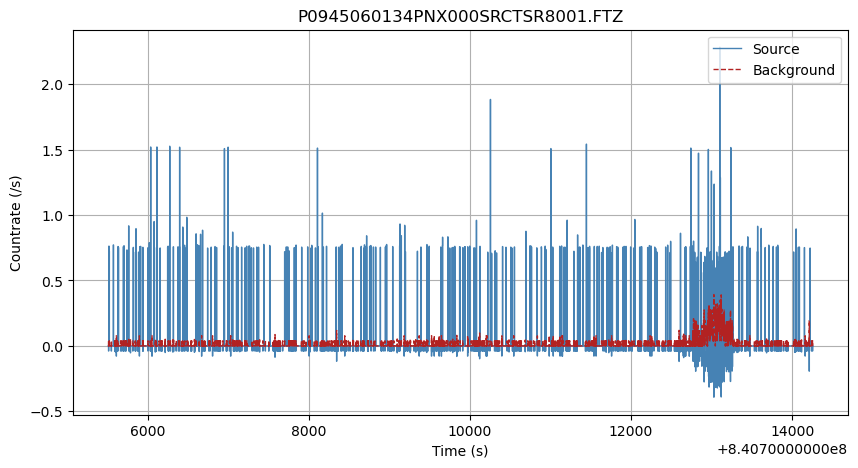

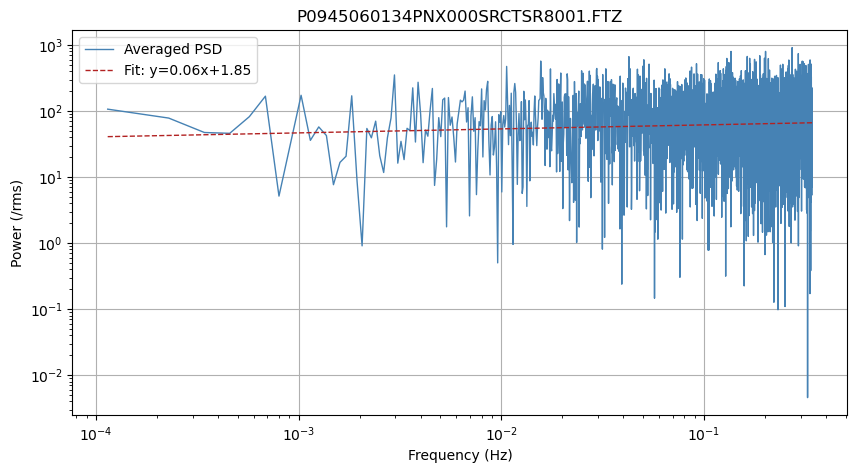

In [5]:
lc_fname = glob.glob("P*PNX*SRCTSR*.FTZ")
gtis, max_gti = gtis(lc_fname[0])
periodicity(lc_fname[0], gtis, max_gti)

### Time bin size = 10s

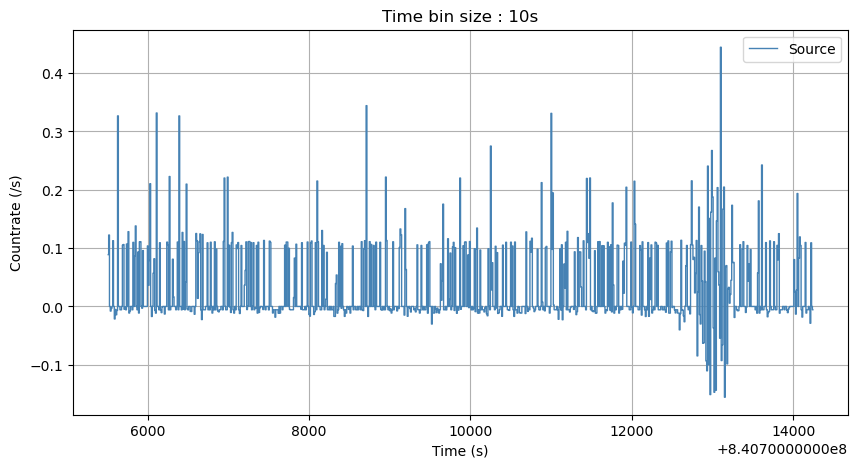

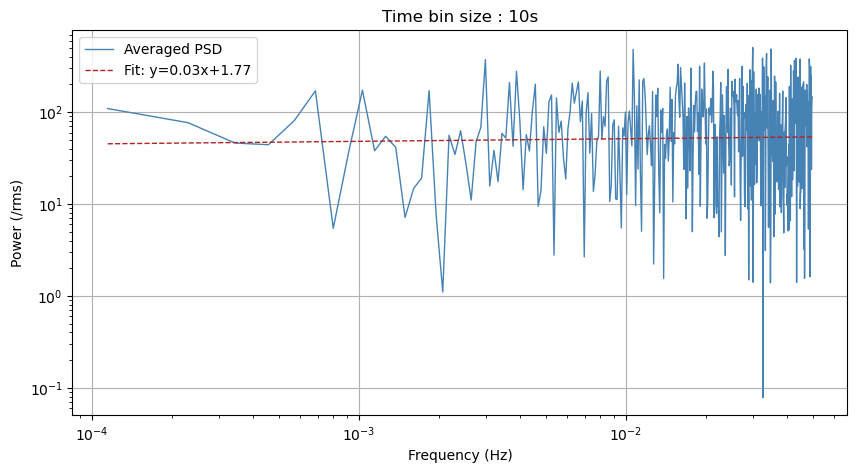

In [6]:
periodicity_rebin(lc_fname[0], gtis, max_gti, 10)

### Time bin size = 50s

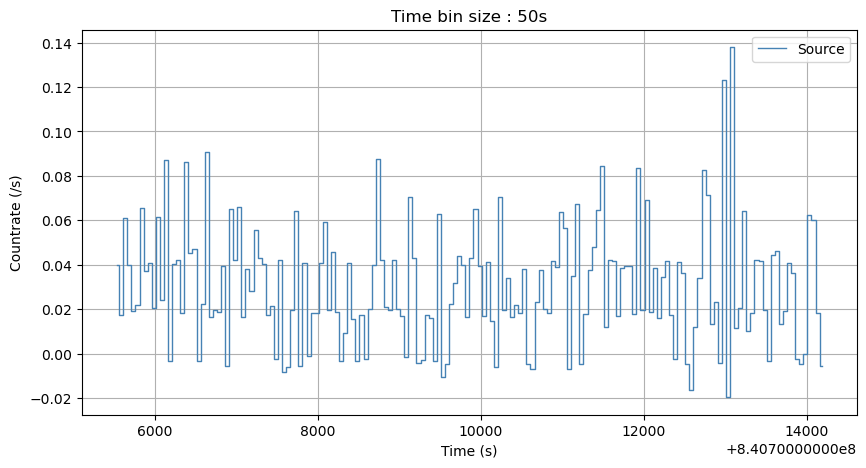

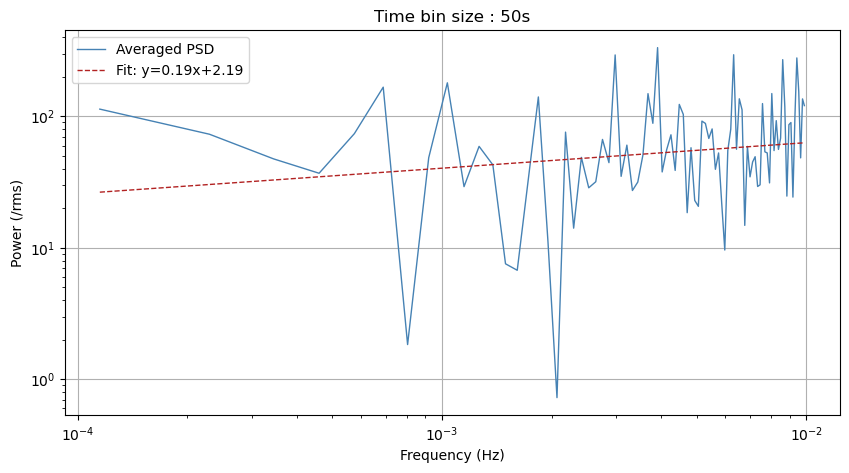

In [7]:
periodicity_rebin(lc_fname[0], gtis, max_gti, 50)

### Time bin size = 200s

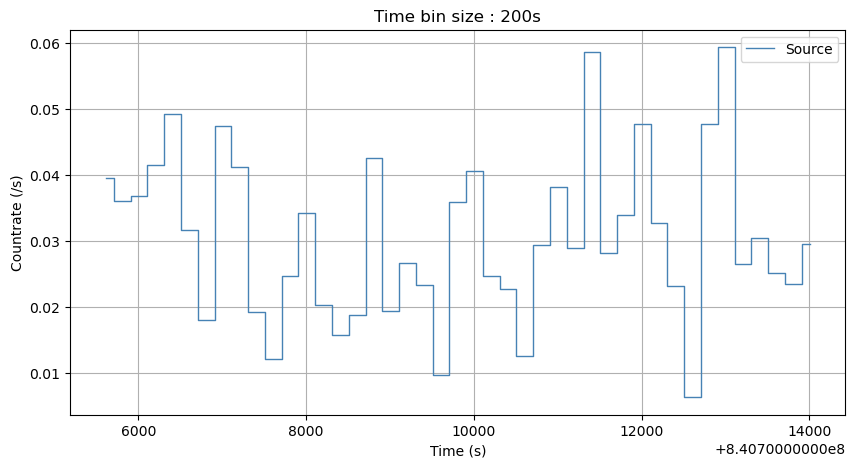

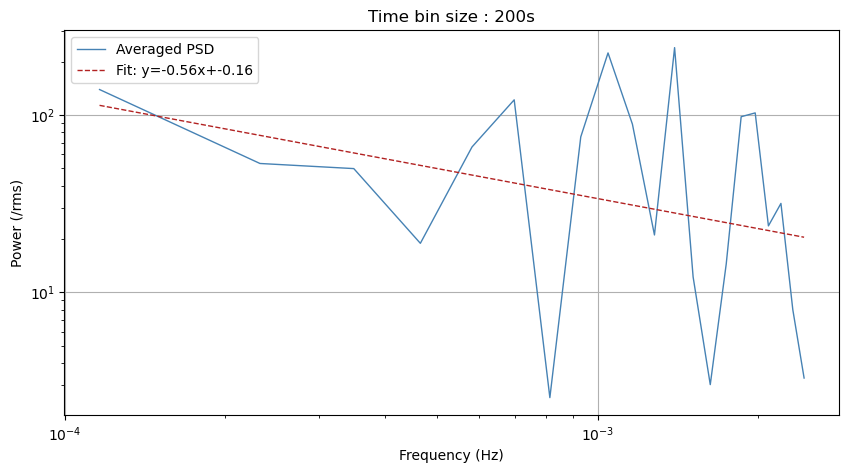

In [8]:
periodicity_rebin(lc_fname[0], gtis, max_gti, 200)

### Time bin size = 500s

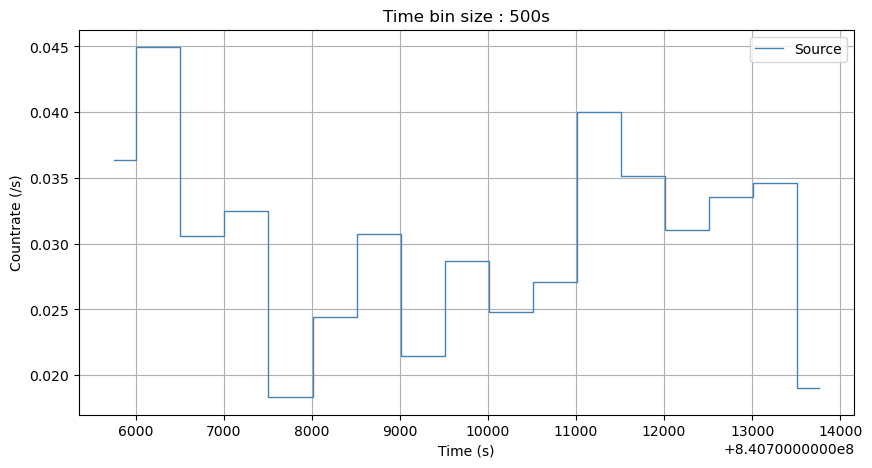

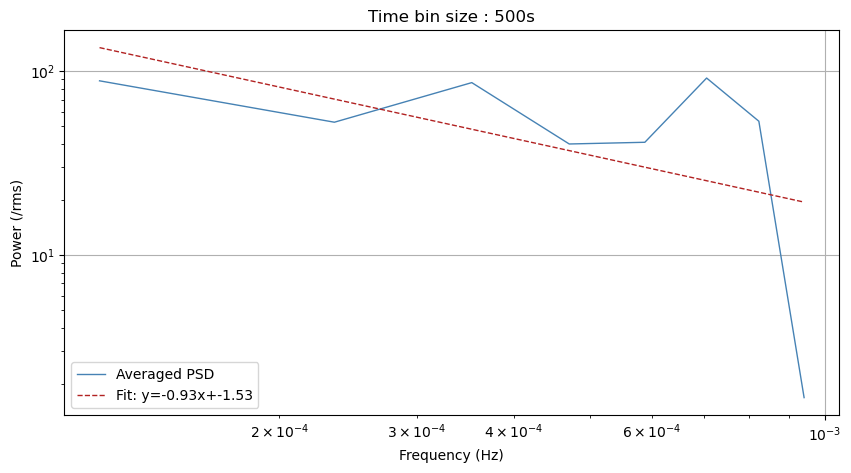

In [9]:
periodicity_rebin(lc_fname[0], gtis, max_gti, 500)

## Event list

### First search

In [10]:
evt_names = glob.glob("*source_events.fits")

source_events = st.EventList.read(evt_names[0],fmt_='hea',skip_checks=True)
source_events.gti = gtis
gti_mask = create_gti_mask(source_events.time,gtis)
clean_times = source_events.time[gti_mask]
clean_events = st.EventList(clean_times, pi=source_events.pi[gti_mask])
clean_events.filter_energy_range([200,12000],inplace=True,use_pi=True)

/home/celia/.local/lib/python3.10/site-packages/stingray/base.py:1226: UserWarning: The time array is not sorted. Sorting it now.
  warnings.warn("The time array is not sorted. Sorting it now.")


In [11]:
obs_length = max(source_events.time) - min(source_events.time)
print("Lenght of the observation :", obs_length)
print()

df_min = 1/obs_length
oversampling=15
df = df_min / oversampling

frequencies = np.arange(2*df_min, 5, df)
print("frequencies :", frequencies)

Lenght of the observation : 8456.948361992836

frequencies : [2.36491925e-04 2.44374989e-04 2.52258054e-04 ... 4.99998323e+00
 4.99999111e+00 4.99999900e+00]


In [12]:
freq, efstat = epoch_folding_search(clean_events.time, frequencies, nbin=32, gti=gtis)
freq, zstat = z_n_search(clean_events.time, frequencies, nbin=32, nharm=1, gti=gtis)

In [13]:
ntrial = (frequencies[-1] - frequencies[0]) / df_min
z_detlev = z2_n_detection_level(n=1, epsilon=0.001, ntrial=len(freq))
ef_detlev = fold_detection_level(32, epsilon=0.001, ntrial=len(freq))

In [14]:
cand_freqs_ef, cand_stat_ef = search_best_peaks(freq, efstat, ef_detlev)
cand_freqs_z, cand_stat_z = search_best_peaks(freq, zstat, z_detlev)

print(f"Number of significant frequencies detected by Epoch folding : {len(cand_freqs_ef)}.")
for i in range(len(cand_freqs_ef)):
    print("cand_freqs_ef :", cand_freqs_ef[i], "cand_stat_ef :", cand_stat_ef[i])

print()
print(f"Number of significant frequencies detected by Zn test : {len(cand_freqs_z)}.")
for i in range(len(cand_freqs_z)):
    print("cand_freqs_z :", cand_freqs_z[i], "cand_stat_z :", cand_stat_z[i])

Number of significant frequencies detected by Epoch folding : 4.
cand_freqs_ef : 0.00023649192526566527 cand_stat_ef : 434.1066666666667
cand_freqs_ef : 0.0009932660861157953 cand_stat_ef : 109.41333333333331
cand_freqs_ef : 0.001016915278642362 cand_stat_ef : 106.85333333333331
cand_freqs_ef : 0.0008671370593074403 cand_stat_ef : 103.01333333333332

Number of significant frequencies detected by Zn test : 3.
cand_freqs_z : 0.0002916733744943206 cand_stat_z : 122.19260497862847
cand_freqs_z : 0.0011824596263283278 cand_stat_z : 43.53405528174337
cand_freqs_z : 0.0011272781770996726 cand_stat_z : 40.744130052157125


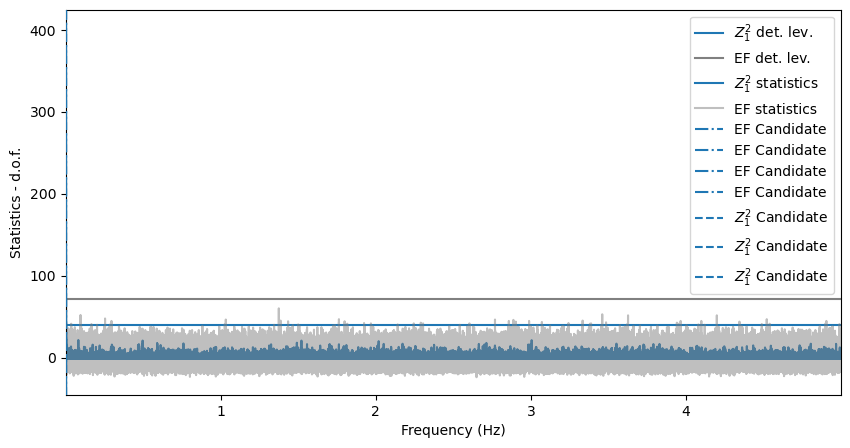

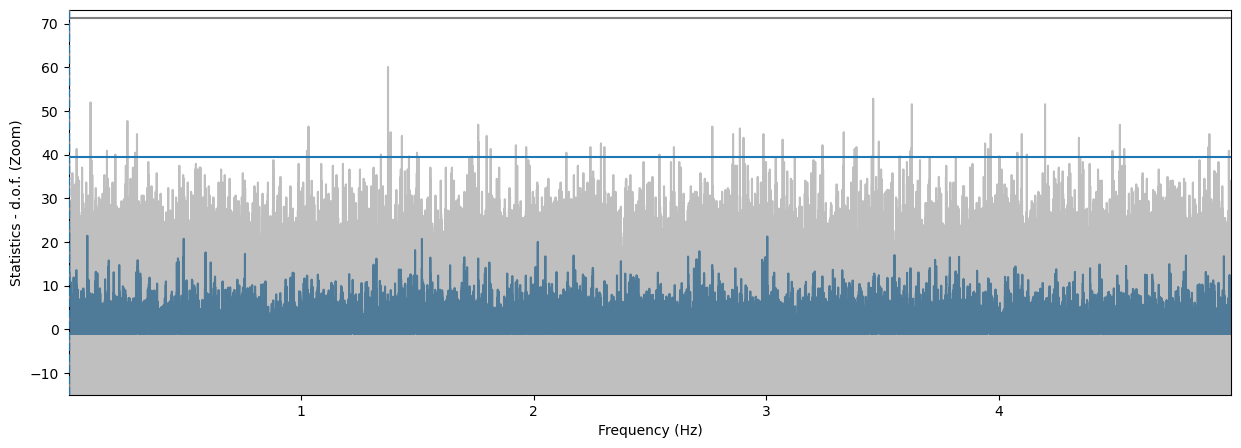

In [15]:
nharm=1
nbin=32

plt.figure()
plt.axhline(z_detlev - nharm, label='$Z^2_1$ det. lev.')
plt.axhline(ef_detlev - nbin + 1, label='EF det. lev.', color='gray')

plt.plot(freq, (zstat - nharm), label='$Z^2_1$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

for c in cand_freqs_ef:
    plt.axvline(c, ls='-.', label='EF Candidate', zorder=10)
for c in cand_freqs_z:
    plt.axvline(c, ls='--', label='$Z^2_1$ Candidate', zorder=10)

#plt.axvline(1/period, color='r', lw=3, alpha=0.5, label='Correct frequency')
plt.xlim([frequencies[0], frequencies[-1]])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f.')
plt.legend()

plt.figure(figsize=(15, 5))
plt.plot(freq, (zstat - nharm), label='$Z_2$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

#plt.axvline(1/period, color='r', lw=3, alpha=0.5, label='Correct frequency')
plt.axhline(z_detlev - nharm, label='$Z^2_1$ det. lev.', zorder=10)
plt.axhline(ef_detlev - nbin + 1, label='EF det. lev.', color='gray', zorder=10)

for c in cand_freqs_ef:
    plt.axvline(c, ls='-.', label='EF Candidate', color='gray', zorder=10)
for c in cand_freqs_z:
    plt.axvline(c, ls='--', label='$Z^2_1$ Candidate', zorder=10)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f. (Zoom)')

plt.ylim([-15, ef_detlev - nbin + 3])
_ = plt.xlim([frequencies[0], frequencies[-1]])

### Second search
The search is now targeted around the canditates frequencies :
- f0_ef = 0.00023649192526566527
- f0_z = 0.0002916733744943206

In [33]:
obs_length = max(source_events.time) - min(source_events.time)
print("Lenght of the observation :", obs_length)
print()

df_min = 1/obs_length
oversampling=15
df = df_min / oversampling

frequencies = np.arange(0.0002, 0.0003, df/10)
print("frequencies :", frequencies)

Lenght of the observation : 8456.948361992836

frequencies : [0.0002     0.00020079 0.00020158 0.00020236 0.00020315 0.00020394
 0.00020473 0.00020552 0.00020631 0.00020709 0.00020788 0.00020867
 0.00020946 0.00021025 0.00021104 0.00021182 0.00021261 0.0002134
 0.00021419 0.00021498 0.00021577 0.00021655 0.00021734 0.00021813
 0.00021892 0.00021971 0.0002205  0.00022128 0.00022207 0.00022286
 0.00022365 0.00022444 0.00022523 0.00022601 0.0002268  0.00022759
 0.00022838 0.00022917 0.00022996 0.00023074 0.00023153 0.00023232
 0.00023311 0.0002339  0.00023469 0.00023547 0.00023626 0.00023705
 0.00023784 0.00023863 0.00023942 0.0002402  0.00024099 0.00024178
 0.00024257 0.00024336 0.00024415 0.00024493 0.00024572 0.00024651
 0.0002473  0.00024809 0.00024887 0.00024966 0.00025045 0.00025124
 0.00025203 0.00025282 0.0002536  0.00025439 0.00025518 0.00025597
 0.00025676 0.00025755 0.00025833 0.00025912 0.00025991 0.0002607
 0.00026149 0.00026228 0.00026306 0.00026385 0.00026464 0.00026543
 0.

In [34]:
freq, efstat = epoch_folding_search(clean_events.time, frequencies, nbin=32, gti=gtis)
freq, zstat = z_n_search(clean_events.time, frequencies, nbin=32, nharm=1, gti=gtis)

ntrial = (frequencies[-1] - frequencies[0]) / df_min
z_detlev = z2_n_detection_level(n=1, epsilon=0.001, ntrial=len(freq))
ef_detlev = fold_detection_level(32, epsilon=0.001, ntrial=len(freq))

In [35]:
cand_freqs_ef, cand_stat_ef = search_best_peaks(freq, efstat, ef_detlev)
cand_freqs_z, cand_stat_z = search_best_peaks(freq, zstat, z_detlev)

print(f"Number of significant frequencies detected by Epoch folding : {len(cand_freqs_ef)}.")
for i in range(len(cand_freqs_ef)):
    print("cand_freqs_ef :", cand_freqs_ef[i], "cand_stat_ef :", cand_stat_ef[i])

print()
print(f"Number of significant frequencies detected by Zn test : {len(cand_freqs_z)}.")
for i in range(len(cand_freqs_z)):
    print("cand_freqs_z :", cand_freqs_z[i], "cand_stat_z :", cand_stat_z[i])

Number of significant frequencies detected by Epoch folding : 1.
cand_freqs_ef : 0.00020078830641755222 cand_stat_ef : 586.4266666666666

Number of significant frequencies detected by Zn test : 1.
cand_freqs_z : 0.0002 cand_stat_z : 138.36015969713506


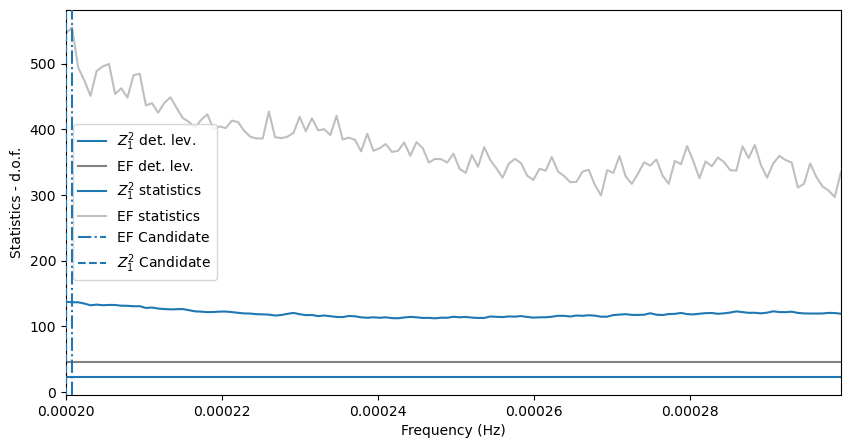

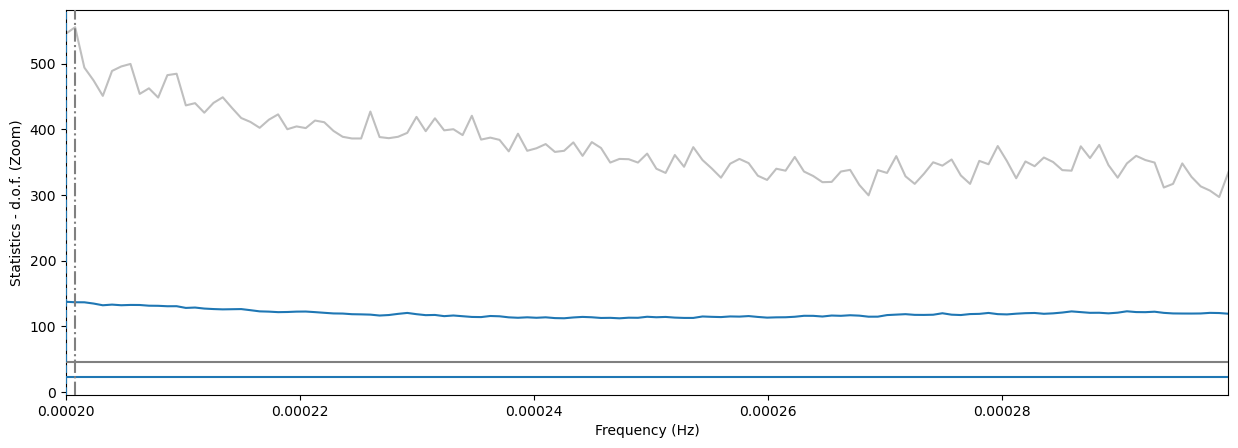

In [36]:
nharm=1
nbin=32

plt.figure()
plt.axhline(z_detlev - nharm, label='$Z^2_1$ det. lev.')
plt.axhline(ef_detlev - nbin + 1, label='EF det. lev.', color='gray')

plt.plot(freq, (zstat - nharm), label='$Z^2_1$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

for c in cand_freqs_ef:
    plt.axvline(c, ls='-.', label='EF Candidate', zorder=10)
for c in cand_freqs_z:
    plt.axvline(c, ls='--', label='$Z^2_1$ Candidate', zorder=10)

#plt.axvline(1/period, color='r', lw=3, alpha=0.5, label='Correct frequency')
plt.xlim([frequencies[0], frequencies[-1]])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f.')
plt.legend()

plt.figure(figsize=(15, 5))
plt.plot(freq, (zstat - nharm), label='$Z_2$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

#plt.axvline(1/period, color='r', lw=3, alpha=0.5, label='Correct frequency')
plt.axhline(z_detlev - nharm, label='$Z^2_1$ det. lev.', zorder=10)
plt.axhline(ef_detlev - nbin + 1, label='EF det. lev.', color='gray', zorder=10)

for c in cand_freqs_ef:
    plt.axvline(c, ls='-.', label='EF Candidate', color='gray', zorder=10)
for c in cand_freqs_z:
    plt.axvline(c, ls='--', label='$Z^2_1$ Candidate', zorder=10)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f. (Zoom)')

#plt.ylim([-15, ef_detlev - nbin + 3])
_ = plt.xlim([frequencies[0], frequencies[-1]])

Period (Epoch folding) : 4980.369712967426
Period (Zn test) : 5000.0
Number of periods : 7.290266666710377


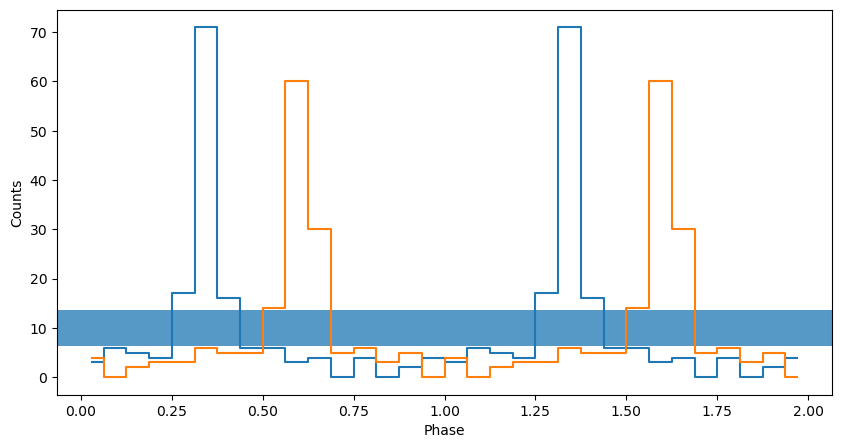

In [51]:
f0_ef = 0.00020078830641755222
f0_z = 0.0002

P_ef = 1 / f0_ef
P_z = 1 / f0_z
print("Period (Epoch folding) :", P_ef)
print("Period (Zn test) :", P_z)

ph_ef, profile_ef, profile_err_ef = fold_events(clean_events.time, f0_ef)
_ = plot_profile(ph_ef,profile_ef) # Blue

ph_z, profile_z, profile_err_z = fold_events(clean_events.time, f0_z)
_ = plot_profile(ph_z,profile_z) # Orange

profile_err_ef
profile_err_z

ph_out_ef = np.concatenate((ph_ef,ph_ef+1))
profile_out_ef = np.concatenate((profile_ef,profile_ef))
prof_err_out_ef = np.concatenate((profile_err_ef,profile_err_ef))

ph_out_z = np.concatenate((ph_z,ph_z+1))
profile_out_z = np.concatenate((profile_z,profile_z))
prof_err_out_z = np.concatenate((profile_err_z,profile_err_z))

np.savetxt('ObsID0945060134_SRCNUM1_EPN_pulse_profile2_ef.csv',(ph_out_ef, profile_out_ef,prof_err_out_ef),delimiter=',')
np.savetxt('ObsID0945060134_SRCNUM1_EPN_pulse_profile2_z.csv',(ph_out_z, profile_out_z,prof_err_out_z),delimiter=',')

print("Number of periods :",max_gti/1200)

In [38]:
err_low_ef, err_high_ef = poisson_conf_interval(np.mean(profile_ef), interval="frequentist-confidence", sigma=1)
print(color.BOLD +"Epoch folding :"+ color.END)
print(f"Mean profile : {np.mean(profile_ef)}, err_low : {err_low_ef}, err_high : {err_high_ef}")
err_low_ef, err_high_ef = poisson_conf_interval(np.mean(profile_ef), interval="frequentist-confidence", sigma=3)
print(f"Mean profile : {np.mean(profile_ef)}, err_low : {err_low_ef}, err_high : {err_high_ef}")
print()

err_low_z, err_high_z = poisson_conf_interval(np.mean(profile_z), interval="frequentist-confidence", sigma=1)
print(color.BOLD +"Zn test :"+ color.END)
print(f"Mean profile : {np.mean(profile_z)}, err_low : {err_low_z}, err_high : {err_high_z}")
err_low_z, err_high_z = poisson_conf_interval(np.mean(profile_z), interval="frequentist-confidence", sigma=3)
print(f"Mean profile : {np.mean(profile_z)}, err_low : {err_low_z}, err_high : {err_high_z}")

Epoch folding :
Mean profile : 9.4375, err_low : 6.420635846267183, err_high : 13.61722990862242
Mean profile : 9.4375, err_low : 2.7880547640709055, err_high : 22.81876657189943

Zn test :
Mean profile : 9.4375, err_low : 6.420635846267183, err_high : 13.61722990862242
Mean profile : 9.4375, err_low : 2.7880547640709055, err_high : 22.81876657189943


### Second search bis
The search is now targeted around the canditates frequencies :
- f0_ef = 0.001016915278642362
- f0_z = 0.0011272781770996726

In [45]:
obs_length = max(source_events.time) - min(source_events.time)
print("Lenght of the observation :", obs_length)
print()

df_min = 1/obs_length
oversampling=15
df = df_min / oversampling

frequencies = np.arange(0.0001, 0.0012, df/10)
print("frequencies :", frequencies)

Lenght of the observation : 8456.948361992836

frequencies : [0.0001     0.00010079 0.00010158 ... 0.00119811 0.0011989  0.00119969]


In [46]:
freq, efstat = epoch_folding_search(clean_events.time, frequencies, nbin=32, gti=gtis)
freq, zstat = z_n_search(clean_events.time, frequencies, nbin=32, nharm=1, gti=gtis)

ntrial = (frequencies[-1] - frequencies[0]) / df_min
z_detlev = z2_n_detection_level(n=1, epsilon=0.001, ntrial=len(freq))
ef_detlev = fold_detection_level(32, epsilon=0.001, ntrial=len(freq))

In [47]:
cand_freqs_ef, cand_stat_ef = search_best_peaks(freq, efstat, ef_detlev)
cand_freqs_z, cand_stat_z = search_best_peaks(freq, zstat, z_detlev)

print(f"Number of significant frequencies detected by Epoch folding : {len(cand_freqs_ef)}.")
for i in range(len(cand_freqs_ef)):
    print("cand_freqs_ef :", cand_freqs_ef[i], "cand_stat_ef :", cand_stat_ef[i])

print()
print(f"Number of significant frequencies detected by Zn test : {len(cand_freqs_z)}.")
for i in range(len(cand_freqs_z)):
    print("cand_freqs_z :", cand_freqs_z[i], "cand_stat_z :", cand_stat_z[i])

Number of significant frequencies detected by Epoch folding : 35.
cand_freqs_ef : 0.0001 cand_stat_ef : 1047.6533333333332
cand_freqs_ef : 0.0009923628646691055 cand_stat_ef : 119.22666666666666
cand_freqs_ef : 0.0010774999577647447 cand_stat_ef : 106.42666666666665
cand_freqs_ef : 0.0009655604464723303 cand_stat_ef : 101.30666666666664
cand_freqs_ef : 0.001089324554028028 cand_stat_ef : 101.30666666666664
cand_freqs_ef : 0.0009356048026053463 cand_stat_ef : 99.59999999999998
cand_freqs_ef : 0.0009537358502090472 cand_stat_ef : 99.59999999999998
cand_freqs_ef : 0.0011610604380252792 cand_stat_ef : 99.17333333333332
cand_freqs_ef : 0.0009576773822968082 cand_stat_ef : 99.17333333333332
cand_freqs_ef : 0.0011768265663763236 cand_stat_ef : 97.89333333333332
cand_freqs_ef : 0.001112185440137042 cand_stat_ef : 97.89333333333332
cand_freqs_ef : 0.0011988991460677855 cand_stat_ef : 97.46666666666664
cand_freqs_ef : 0.0010467560074802083 cand_stat_ef : 97.03999999999998
cand_freqs_ef : 0.00115

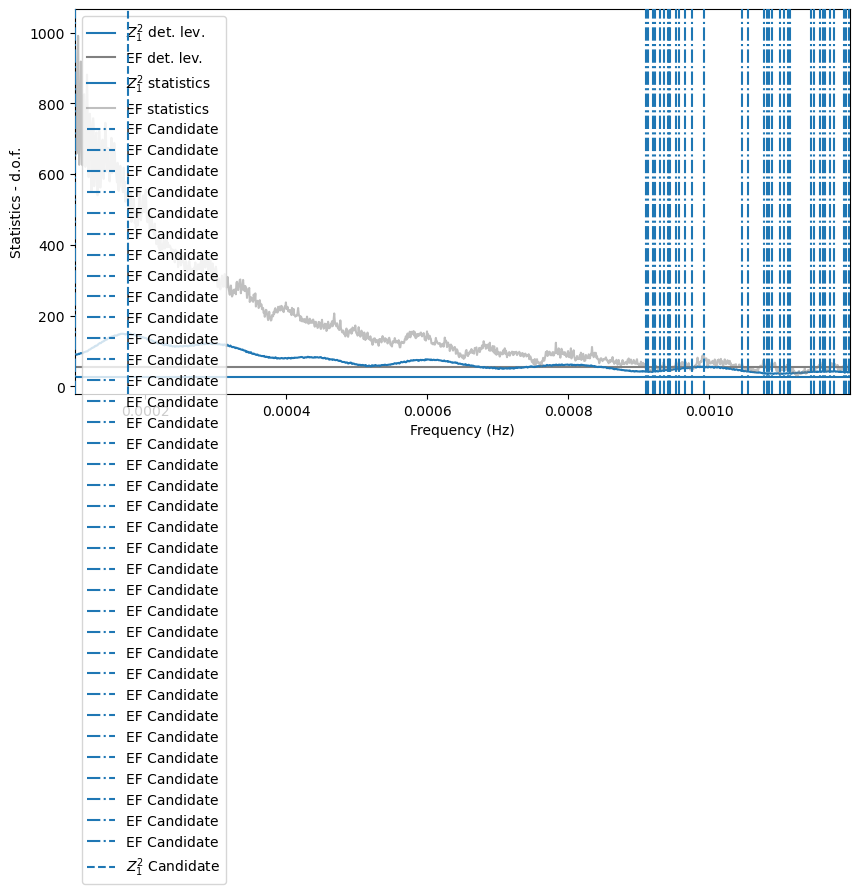

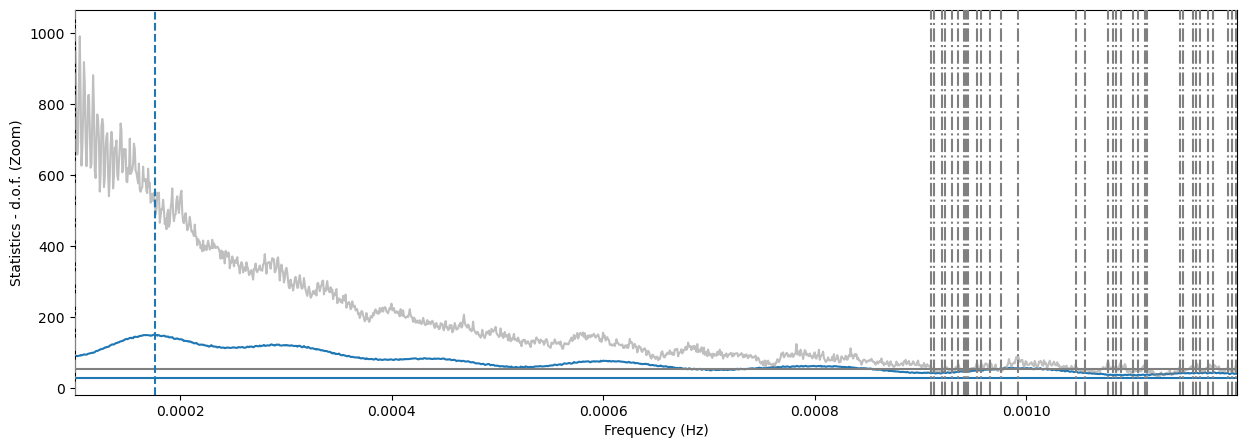

In [48]:
nharm=1
nbin=32

plt.figure()
plt.axhline(z_detlev - nharm, label='$Z^2_1$ det. lev.')
plt.axhline(ef_detlev - nbin + 1, label='EF det. lev.', color='gray')

plt.plot(freq, (zstat - nharm), label='$Z^2_1$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

for c in cand_freqs_ef:
    plt.axvline(c, ls='-.', label='EF Candidate', zorder=10)
for c in cand_freqs_z:
    plt.axvline(c, ls='--', label='$Z^2_1$ Candidate', zorder=10)

#plt.axvline(1/period, color='r', lw=3, alpha=0.5, label='Correct frequency')
plt.xlim([frequencies[0], frequencies[-1]])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f.')
plt.legend()

plt.figure(figsize=(15, 5))
plt.plot(freq, (zstat - nharm), label='$Z_2$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

#plt.axvline(1/period, color='r', lw=3, alpha=0.5, label='Correct frequency')
plt.axhline(z_detlev - nharm, label='$Z^2_1$ det. lev.', zorder=10)
plt.axhline(ef_detlev - nbin + 1, label='EF det. lev.', color='gray', zorder=10)

for c in cand_freqs_ef:
    plt.axvline(c, ls='-.', label='EF Candidate', color='gray', zorder=10)
for c in cand_freqs_z:
    plt.axvline(c, ls='--', label='$Z^2_1$ Candidate', zorder=10)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f. (Zoom)')

#plt.ylim([-15, ef_detlev - nbin + 40])
_ = plt.xlim([frequencies[0], frequencies[-1]])

Period (Zn test) : 5692.251299484548
Number of periods : 1.536882252694051


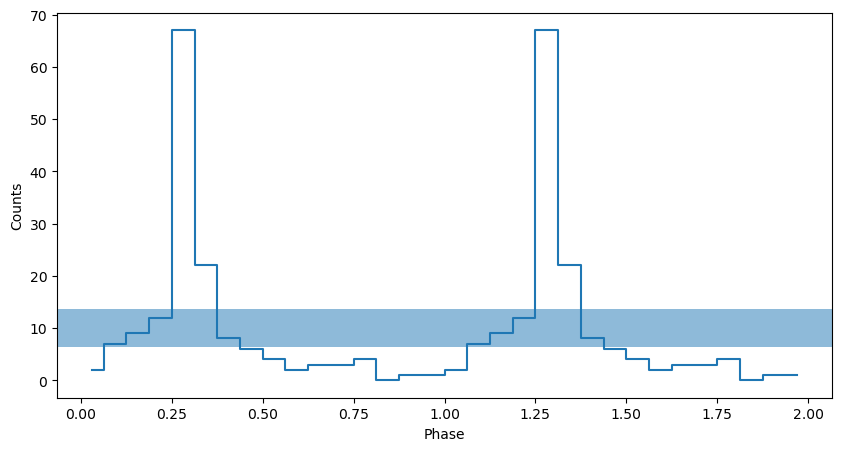

In [52]:
f0_z = 0.00017567741608501248

P_z = 1 / f0_z
print("Period (Zn test) :", P_z)

ph_z, profile_z, profile_err_z = fold_events(clean_events.time, f0_z)
_ = plot_profile(ph_z,profile_z)

profile_err_z

ph_out_z = np.concatenate((ph_z,ph_z+1))
profile_out_z = np.concatenate((profile_z,profile_z))
prof_err_out_z = np.concatenate((profile_err_z,profile_err_z))

np.savetxt('ObsID0945060134_SRCNUM1_EPN_pulse_profile3_z.csv',(ph_out_z, profile_out_z,prof_err_out_z),delimiter=',')

print("Number of periods :",max_gti/P_z)

In [50]:
err_low_z, err_high_z = poisson_conf_interval(np.mean(profile_z), interval="frequentist-confidence", sigma=1)
print(color.BOLD +"Zn test :"+ color.END)
print(f"Mean profile : {np.mean(profile_z)}, err_low : {err_low_z}, err_high : {err_high_z}")
err_low_z, err_high_z = poisson_conf_interval(np.mean(profile_z), interval="frequentist-confidence", sigma=3)
print(f"Mean profile : {np.mean(profile_z)}, err_low : {err_low_z}, err_high : {err_high_z}")

Zn test :
Mean profile : 9.4375, err_low : 6.420635846267183, err_high : 13.61722990862242
Mean profile : 9.4375, err_low : 2.7880547640709055, err_high : 22.81876657189943
